In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [20]:
MIN_MATCH_COUNT = 10

In [36]:
img1 = cv.imread('processed/FulliconStatusEffects_bleeding.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('test/AllStatusEffects.webp', cv.IMREAD_GRAYSCALE)


In [37]:
# Initiate SIFT detector
sift = cv.SIFT_create()


In [44]:
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

In [45]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 100)

In [46]:
flann = cv.FlannBasedMatcher(index_params, search_params)

In [47]:
matches = flann.knnMatch(des1,des2,k=2)

In [ ]:
matchesMask = [[0,0] for i in range(len(matches))]

for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

In [50]:
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)

In [51]:
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

## Start of homography

In [48]:
# store all the good matches as per Lowe's ratio test.
good = []

In [49]:
# ratio test as per Lowe's paper
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [32]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

Not enough matches are found - 1/10


In [33]:
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = None,
                   matchesMask = matchesMask,
                   flags = 2)

In [34]:
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,**draw_params)

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'drawMatchesKnn'
> Overload resolution failed:
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type


## End of homography

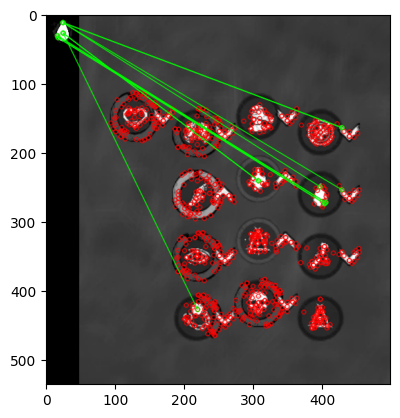

(<matplotlib.image.AxesImage at 0x2be4ca619f0>, None)

In [52]:
plt.imshow(img3,),plt.show()